In [7]:
import sys
sys.path.append('../')
import numpy as np
import importlib
import utils as u
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Activation, Dropout
from tensorflow.keras.regularizers import L1L2
import tensorflow.keras.backend as K
importlib.reload(u)

<module 'utils' from '..\\utils.py'>

In [8]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

In [2]:
datadict = u.load_covid_timeseries(smoothing=3, cases_cutoff=0)
cases = datadict['cases_calibrated']
deaths = datadict['deaths_calibrated']

NameError: name 'u' is not defined

In [10]:
demographics = u.load_demographics_data()
demographics

,FIPS,total_pop,60plus,area,median_age,pop_white,pop_black,pop_hispanic
0,1001,55036,10523,594.44,37.8,76.9,19.1,2.8
1,1003,203360,53519,1589.78,42.8,86.3,9.5,4.5
2,1005,26201,6150,884.88,39.9,47.4,47.6,4.3
3,1007,22580,4773,622.58,39.9,76.7,22.3,2.4
4,1009,57667,13600,644.78,40.8,95.5,1.5,9.1
...,...,...,...,...,...,...,...,...
3138,56039,22923,4298,3995.38,39.3,90.3,1.2,14.9
3139,56041,20758,3554,2081.26,35.5,93.4,0.1,9.1
3140,56043,8253,2206,2238.55,43.5,89.7,0.0,14.2
3141,56045,7117,2073,2398.09,42.9,92.5,0.5,1.5


In [11]:
pop = np.expand_dims(demographics['total_pop'].values, axis=1)
cases_norm = cases / pop * 10000
deaths_norm = deaths / pop * 10000

In [12]:
def transform(x):
    x0 = np.expand_dims(x[:, 0], axis=1)
    t = np.diff(x)
    t0 = np.expand_dims(t[:, 0], axis=1)
    t = np.diff(t)
    return t, t0, x0

In [13]:
def untransform(t, t0, x0, a=1):
    x = np.hstack([t0, t])
    x = np.cumsum(x, axis=a)
    x = np.hstack([x0, x])
    x = np.cumsum(x, axis=a)
    return x

In [14]:
cases2, ct0, cx0 = transform(cases_norm)
deaths2, dt0, dx0 = transform(deaths_norm)

(3143, 95)


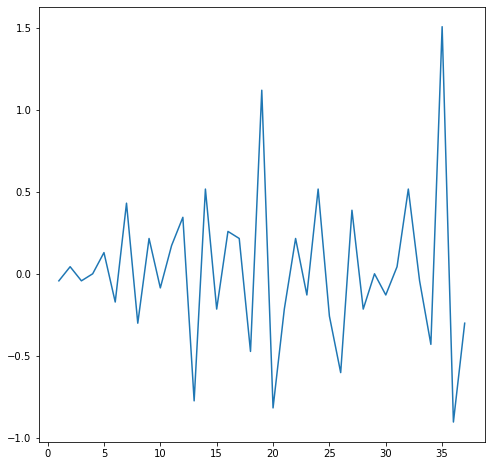

In [40]:
d = cases2
x1 = np.linspace(1, d.shape[1], d.shape[1])
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plt.plot(x1, d[1860])
print(d.shape)
plt.show()

In [41]:
X_train = []
y_train = []
X_test = []
y_test = []
lag = 7
k = 7
validation_steps = 9
for j in range(deaths2.shape[0]):
    d = deaths2[j]
    c = cases2[j]
    if np.all(np.isnan(d)) or np.all(np.isnan(c)):
        continue
    s = np.argmax(np.isnan(d))
    for i in range(s):
        if np.any(np.isnan(d[i:i+lag+k])) or np.any(np.isnan(c[i:i+lag+k])):
            break
        x = np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag,), i)]).T
        if i < s - validation_steps - lag - k:
            X_train.append(x)
            y_train.append(np.vstack([c[i+lag:i+lag+k], d[i+lag:i+lag+k]]).T)
        else:
            X_test.append(x)
            y_test.append(np.vstack([c[i+lag:i+lag+k], d[i+lag:i+lag+k]]).T)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [42]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(28229, 7, 3) (28229, 7, 2) (25312, 7, 3) (25312, 7, 2)


In [50]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(64, input_shape=X_train.shape[1:], activation='relu', return_sequences=True, recurrent_regularizer=L1L2(0,1e-2), kernel_regularizer=L1L2(0, 0.1)))
    model.add(TimeDistributed(Dense(2, kernel_regularizer=L1L2(0.1, 0.1))))
    return model

In [51]:
def pinball_loss(q, pred, true):
    e = pred - true
    return K.mean(K.maximum(q*e, (q-1)*e))

In [55]:
def get_model(q):
    model = LSTM_model()
    model.compile(loss=lambda pred, true: pinball_loss(q, pred, true), optimizer='adam')
    return model

def fit_model(model, X_train, y_train):
    model.fit(X_train, y_train, epochs=30, batch_size=72, verbose=2, shuffle=True)
    return model

def get_predictions(model):
    cases_predictions = {}
    deaths_predictions = {}
    count = 0
    for county in range(deaths2.shape[0]):
        count += 1
        if count % 50 == 0:
            print(count)
        d = deaths2[county]
        c = cases2[county]
        if np.all(np.isnan(d)) or np.all(np.isnan(c)):
            continue
        s = np.argmax(np.isnan(d))
        if s < lag:
            continue
        i = s - lag
        X = np.expand_dims(np.vstack([c[i:i+lag], d[i:i+lag], np.full((lag, ), i)]).T, axis=0)
        predictions1 = model.predict(X)
        X = np.expand_dims(np.hstack([predictions1[0], np.full((lag, 1), i)]), axis=0)
        predictions2 = model.predict(X)
        predictions = np.vstack([predictions1[0], predictions2[0]])
        cases_predictions[county] = predictions.T[0]
        deaths_predictions[county] = predictions.T[1]
    return cases_predictions, deaths_predictions

def get_total(cases_predictions, deaths_predictions):
    cp2 = {}
    dp2 = {}
    pop = np.expand_dims(demographics['total_pop'].values, axis=1)
    for county in cases_predictions:
        d = deaths2[county]
        c = cases2[county]
        s = np.argmax(np.isnan(d))
        d2 = np.concatenate([d[:(s)], deaths_predictions[county]])
        c2 = np.concatenate([c[:(s)], cases_predictions[county]])

        cp2[county] = untransform(c2, ct0[county], cx0[county], 0)
        dp2[county] = untransform(d2, dt0[county], dx0[county], 0)

        cp2[county] = cp2[county] * pop[county, 0] / 10000
        dp2[county] = dp2[county] * pop[county, 0] / 10000
    
    return cp2, dp2

In [56]:
forecast_deaths = {}
forecast_cases = {}

for q in [0.15, 0.2, 0.275, 0.35, 0.5, 0.55, 0.6, 0.675, 0.75]:
    model = get_model(q)
    model = fit_model(model, X_train, y_train)
    cases_predictions, deaths_predictions = get_predictions(model)
    cp2, dp2 = get_total(cases_predictions, deaths_predictions)
    
    forecast_deaths[q] = dp2
    forecast_cases[q] = cp2

Epoch 1/30
393/393 - 5s - loss: 0.8320
Epoch 2/30
393/393 - 5s - loss: 0.1042
Epoch 3/30
393/393 - 5s - loss: 0.1038
Epoch 4/30
393/393 - 5s - loss: 0.1039
Epoch 5/30
393/393 - 5s - loss: 0.1038
Epoch 6/30
393/393 - 5s - loss: 0.1040
Epoch 7/30
393/393 - 5s - loss: 0.1038
Epoch 8/30
393/393 - 5s - loss: 0.1040
Epoch 9/30
393/393 - 5s - loss: 0.1039
Epoch 10/30
393/393 - 5s - loss: 0.1040
Epoch 11/30
393/393 - 5s - loss: 0.1040
Epoch 12/30
393/393 - 5s - loss: 0.1041
Epoch 13/30
393/393 - 5s - loss: 0.1038
Epoch 14/30
393/393 - 5s - loss: 0.1043
Epoch 15/30
393/393 - 5s - loss: 0.1039
Epoch 16/30
393/393 - 5s - loss: 0.1039
Epoch 17/30
393/393 - 5s - loss: 0.1041
Epoch 18/30
393/393 - 5s - loss: 0.1039
Epoch 19/30
393/393 - 5s - loss: 0.1038
Epoch 20/30
393/393 - 5s - loss: 0.1039
Epoch 21/30
393/393 - 5s - loss: 0.1039
Epoch 22/30
393/393 - 5s - loss: 0.1040
Epoch 23/30
393/393 - 5s - loss: 0.1039
Epoch 24/30
393/393 - 5s - loss: 0.1048
Epoch 25/30
393/393 - 5s - loss: 0.1045
Epoch 26/

In [62]:
from datetime import date, timedelta
start = date.today() - timedelta(days=2)
print(str(start))

2020-04-27


In [206]:
dd = u.load_covid_static()
dd[dd['FIPS'] == '02198']

,FIPS,County Name,cases,deaths,log_cases,log_deaths
87,02198,Prince of Wales-Hyder Census Area,2,0,0.30103,0.0


In [321]:
fips_data = u.load_covid_raw()[0]['FIPS']
fips_data[2696]

'48347'

In [322]:
fips_data[3142] = '66010'
fips_data

0       01001
1       01003
2       01005
3       01007
4       01009
        ...  
3138    56039
3139    56041
3140    56043
3141    56045
3142    66010
Name: FIPS, Length: 3143, dtype: object

In [97]:
import datetime as dt
print(dt.datetime.strptime('4/1/20', '%m/%d/%y'))

2020-04-01 00:00:00


In [113]:
start = dt.datetime.strptime('4/28/20', '%m/%d/%y').date()
curr = date.today() - timedelta(days=1)
print(str(start))

2020-04-28


In [420]:
strs_added = set()

In [421]:
predictions = []
for county in range(deaths2.shape[0]):
    if fips_data[county] in ['36061']:
        continue
    if county not in deaths_predictions:
        start = dt.datetime.strptime('4/1/20', '%m/%d/%y').date()
        end = dt.datetime.strptime('7/1/20', '%m/%d/%y').date()
        s = str(start) + '-' + fips_data[county].lstrip('0')
        
        if s in do_not_include:
            continue
        
        while start != end:
            predictions.append([str(start) + '-' + fips_data[county].lstrip('0')] + [0 for i in range(9)])
            strs_added.add(str(start) + '-' + fips_data[county].lstrip('0'))
            start = start + timedelta(days=1)
        continue
    quantiles = []
    for q in [0.15, 0.2, 0.275, 0.35, 0.5, 0.55, 0.6, 0.675, 0.75]:
        quantiles.append(np.diff(forecast_deaths[q][county][-15:]))
    quantiles = np.array(quantiles).T
    quantiles[quantiles < 0] = 0
    start = dt.datetime.strptime('4/1/20', '%m/%d/%y').date()
    curr = date.today() - timedelta(days=1)
    s = str(start) + '-' + fips_data[county].lstrip('0')  
    if s in do_not_include:
        continue
    while start != curr:
        predictions.append([str(start) + '-' + fips_data[county].lstrip('0')] + [0 for i in range(9)])
        strs_added.add(str(start) + '-' + fips_data[county].lstrip('0'))
        start = start + timedelta(days=1)
    for i in range(14):
        predictions.append([str(curr) + '-' + fips_data[county].lstrip('0')] + list(quantiles[i]))
        strs_added.add(str(curr) + '-' + fips_data[county].lstrip('0'))
        curr = curr + timedelta(days=1)
    start = curr
    end = dt.datetime.strptime('7/1/20', '%m/%d/%y').date()
    while start != end:
        predictions.append([str(start) + '-' + fips_data[county].lstrip('0')] + [0 for i in range(9)])
        strs_added.add(str(start) + '-' + fips_data[county].lstrip('0'))
        start = start + timedelta(days=1)
        
len(predictions)

285285

In [422]:
nytotal = np.zeros((9, 15))
for county in range(deaths2.shape[0]):
    if fips_data[county] not in ['36085', '36061', '36081', '36047', '36005']:
        continue
    quantiles = []
    for q in [0.15, 0.2, 0.275, 0.35, 0.5, 0.55, 0.6, 0.675, 0.75]:
        quantiles.append(forecast_deaths[q][county][-15:])
    quantiles = np.array(quantiles)
    nytotal += quantiles

nytotal = np.diff(nytotal).T
nytotal[nytotal < 0] = 0
start = dt.datetime.strptime('4/1/20', '%m/%d/%y').date()
curr = date.today() - timedelta(days=1)
while start != curr:
    predictions.append([str(start) + '-' + '36061'] + [0 for i in range(9)])
    strs_added.add(str(start) + '-' + '36061')
    start = start + timedelta(days=1)
for i in range(14):
    predictions.append([str(curr) + '-' + '36061'] + list(nytotal[i]))
    strs_added.add(str(curr) + '-' + '36061')
    curr = curr + timedelta(days=1)
start = curr
end = dt.datetime.strptime('7/1/20', '%m/%d/%y').date()
while start != end:
    predictions.append([str(start) + '-' + '36061'] + [0 for i in range(9)])
    strs_added.add(str(start) + '-' + '36061')
    start = start + timedelta(days=1)

In [423]:
for i in extras:
    predictions.append([str(i)] + [0 for i in range(9)])

In [384]:
u, c = np.unique(mine.index.values, return_counts=True)
dup = u[c > 1]
dup

array(['2020-04-01-36061', '2020-04-02-36061', '2020-04-03-36061',
       '2020-04-04-36061', '2020-04-05-36061', '2020-04-06-36061',
       '2020-04-07-36061', '2020-04-08-36061', '2020-04-09-36061',
       '2020-04-10-36061', '2020-04-11-36061', '2020-04-12-36061',
       '2020-04-13-36061', '2020-04-14-36061', '2020-04-15-36061',
       '2020-04-16-36061', '2020-04-17-36061', '2020-04-18-36061',
       '2020-04-19-36061', '2020-04-20-36061', '2020-04-21-36061',
       '2020-04-22-36061', '2020-04-23-36061', '2020-04-24-36061',
       '2020-04-25-36061', '2020-04-26-36061', '2020-04-27-36061',
       '2020-04-28-36061', '2020-04-29-36061', '2020-04-30-36061',
       '2020-05-01-36061', '2020-05-02-36061', '2020-05-03-36061',
       '2020-05-04-36061', '2020-05-05-36061', '2020-05-06-36061',
       '2020-05-07-36061', '2020-05-08-36061', '2020-05-09-36061',
       '2020-05-10-36061', '2020-05-11-36061', '2020-05-12-36061',
       '2020-05-13-36061', '2020-05-14-36061', '2020-05-15-360

In [424]:
len(predictions)

293293

In [402]:
import pandas as pd
mine = pd.read_csv('predictions.csv').set_index('id').sort_index()
sample = pd.read_csv('sample_submission.csv').set_index('id').sort_index()

In [403]:
mine.index.values.shape

(292929,)

In [404]:
sample.index.values.shape

(293293,)

In [405]:
a = set(sample.index.values)
b = set(mine.index.values)
print(len(a), len(b))

293293 292929


In [406]:
#extras = []
for i in a:
    if i not in b:
        pass
        print(i)
        #predictions.append([str(i)] + [0 for i in range(9)])
        #extras.append(i)
print(len(extras))

2020-05-05-36005
2020-04-24-36085
2020-06-01-36081
2020-04-20-36005
2020-06-11-36047
2020-04-20-36085
2020-06-19-36085
2020-06-10-36081
2020-06-06-36005
2020-06-16-36047
2020-06-17-36081
2020-06-25-36085
2020-06-18-36005
2020-06-15-36005
2020-04-06-36085
2020-04-14-36047
2020-06-06-36085
2020-04-28-36047
2020-06-02-36081
2020-04-05-36085
2020-06-22-36005
2020-04-25-36005
2020-05-10-36085
2020-04-11-36085
2020-06-06-36047
2020-06-12-36047
2020-04-02-36081
2020-06-18-36047
2020-05-20-36081
2020-06-09-36047
2020-04-01-36047
2020-06-19-36005
2020-04-22-36005
2020-05-24-36005
2020-04-24-36081
2020-05-17-36005
2020-05-09-36085
2020-06-21-36005
2020-06-30-36081
2020-04-19-36047
2020-06-17-36085
2020-04-26-36085
2020-05-01-36085
2020-05-04-36047
2020-04-08-36005
2020-05-30-36005
2020-04-19-36085
2020-06-01-36005
2020-05-21-36005
2020-06-26-36005
2020-06-05-36047
2020-06-29-36085
2020-06-12-36085
2020-05-06-36005
2020-06-25-36005
2020-04-07-36005
2020-05-05-36085
2020-05-11-36085
2020-05-17-360

In [399]:
#do_not_include = []
for i in b:
    if i not in a:
        pass
        #print(i)
        #do_not_include.append(i)
#do_not_include = set(do_not_include)
print(len(do_not_include))

637


In [400]:
len(do_not_include)

637

In [425]:
import csv
with open("predictions.csv", "w+", newline='') as f:
        csv_writer = csv.writer(f, delimiter = ",")
        csv_writer.writerows([['id', '10', '20', '30', '40', '50', '60', '70', '80', '90']])
        csv_writer.writerows(predictions)

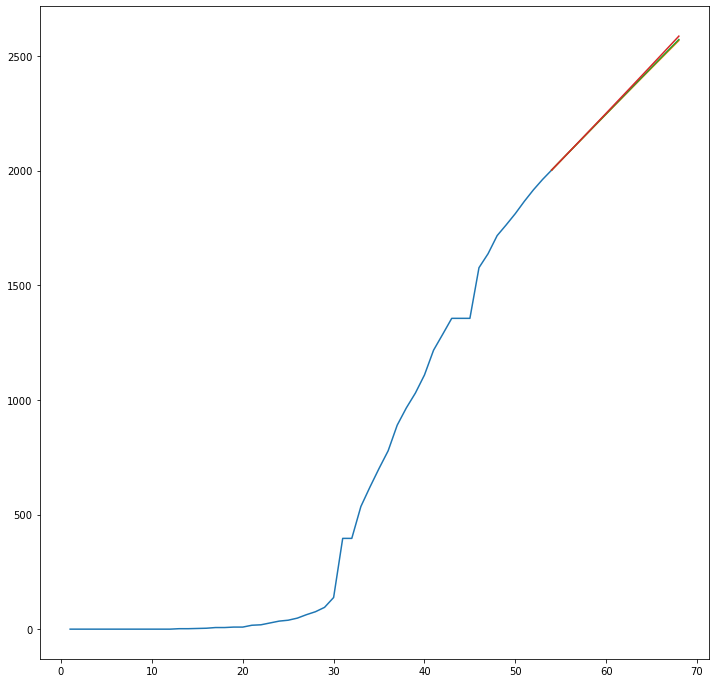

In [84]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

county = 1857

d1 = deaths
x1 = np.linspace(1, d1.shape[1], d1.shape[1])
plt.plot(x1, d1[county])

s = np.argmax(np.isnan(d1[county])) - 1
d2 = forecast_deaths[0.15][county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s:], d2[s:])

d2 = forecast_deaths[0.5][county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s:], d2[s:])

d2 = forecast_deaths[0.75][county]
x2 = np.linspace(1, d2.shape[0], d2.shape[0])
plt.plot(x2[s:], d2[s:])

plt.show()